In [1]:
import nbimporter
import numpy as np
import matplotlib.pyplot as plt
import time
import BalanceEquation
import PropertyConversion as prop
import MoistureConversion as mc

Importing Jupyter notebook from BalanceEquation.ipynb
Importing Jupyter notebook from PropertyConversion.ipynb
Importing Jupyter notebook from MoistureConversion.ipynb
Importing Jupyter notebook from BentheimerSandstone.ipynb
Importing Jupyter notebook from vanGenuchten.ipynb


### 1次元モデルの差分計算をするためのモデュール

#### クラス：Cell( i )  
構造体としてのクラス  

物理情報  
・i：セルの位置    
・dx：セルの大きさ  
・material：材料の種類  

環境情報  
・temp：温度  
・rh：相対湿度  
・miu：水分化学ポテンシャル  
・pv：水蒸気圧  

物性情報  
・crow：熱容量（比熱×密度）  
・lam：熱伝達率  
・phi：含水率
・dphi：含水率の水分化学ポテンシャル微分  
・ldp：透湿率  
・ldml：水分化学ポテンシャル勾配に対する液相水分伝導率

In [2]:
class  Cell():
    def __init__( self, i ):
        self.position = i
    
    # cell information
    def setMaterial( self, initial=0.0 ):
        self.material = initial
    def setDx( self, initial = 0.0 ):
        self.dx = initial 
    
    # initial condition
    def setTemp( self, initial = 0.0 ):
        self.temp = initial
    def setRH( self, initial=0.0  ):
        self.rh = initial
    def setMiu( self, initial=0.0 ):
        self.miu = initial
    def setPv( self, initial=0.0 ):
        self.pv = initial
        
    # physical property
    def setCRow( self, initial=0.0):
        self.crow = initial
    def setLAM( self, initial=0.0):
        self.lam = initial
    def setPhi( self, initial=0.0):
        self.phi = initial
    def setDPhi( self, initial=0.0):
        self.dphi = initial
    def setLDP(self,initial=0.0):
        self.ldp = initial
    def setLDML( self, initial=0.0):
        self.ldml = initial
    

In [3]:
# 使用例
c = [ Cell(i) for i in range(10)]

[ c[i].setDx(0.01*i) for i in range(10)] 
[ c[i].setTemp(293.16+i) for i in range(10)]  
[ c[i].setPv( mc.cal_RHtoPv( c[i].temp, 0.6 ) ) for i in range(10)] 
[ c[i].setMiu( mc.cal_RHtoMiu( c[i].temp, 0.6 ) ) for i in range(10)] 
[ c[i].setLAM(  10  ) for i in range( 10 )]
[ c[i].setLDP(  10   ) for i in range( 10 )]
[ c[i].setLDML( 10 ) for i in range( 10 )]

print(c[2].temp)

295.16


#### クラス：Flus( mns, pls )  
流量計算のためのクラス  
mns：前のセル情報  
pls：後のセル情報  
dtemp：セル間の温度差（前－後）  
dmoisture：セル間の水分量差（前－後）  
dx2：セルの質点間の距離（前－後）  

#### 材料物性値の調和平均を取る関数

In [4]:
def average( val_mns, val_pls, len_mns, len_pls):
    return ( val_mns * len_mns + val_pls * len_pls ) / ( len_mns + len_pls )

#### フーリエの熱伝導  
定義：$\dot q = -\lambda\nabla・T$  
$\dot q$：単位時間当たりの熱流量の密度[W/m2]  
$\lambda$：熱伝導率[W/mK]  
$T$：絶対温度[K]  

In [5]:
def heatConduction( LAM, dtemp, dx2 ):
    return LAM * dtemp / dx2

#### 気相水分流（水蒸気圧勾配・固体内）  
定義：$J_v = -\lambda^{'}_{p}\nabla・P_v$  
$J_v$：気相水分流量[kg/m2s]  
$\lambda^{'}_{p}$：水蒸気圧勾配に関する気相水分伝導率[kg/msPa]  
$P_v$：水蒸気圧[Pa]  

In [6]:
def vapourTransfer_pressure( LDP, dpv, dx2 ):
    return LDP * dpv /dx2

#### 液相水分流（水分化学ポテンシャル勾配・固体内）  
定義：$J_l = -\lambda^{'}_{\mu l}(\nabla・\mu+n_x g)$  
$\lambda^{'}_{\mu l}$：水分化学ポテンシャル勾配に関する液相水分伝導率[kg/ms(J/kg)]  

In [7]:
def liquidTransfer_potential( LDML, dmiu, dx2, nx ):
    grav = 9.806650
    return LDML * ( dmiu / dx2 - nx * grav )

#### Fluxクラス

In [8]:
class Flux():
    def __init__( self, Length, mns, pls, nx ):
        self.mns = mns
        self.pls = pls
        self.nx  = nx # 重力に対する応答方向
        
        # 質点間の距離
        if self.mns.position == 0:
            self.dx2 = self.mns.dx + self.pls.dx / 2.0
        elif self.pls.position == Length-1 :
            self.dx2 = self.mns.dx / 2.0 + self.pls.dx
        else :
            self.dx2 = self.mns.dx / 2.0 + self.pls.dx / 2.0
        
    # 熱流計算
    def heat( self ):
        self.dtemp = self.mns.temp - self.pls.temp
        self.dlam  = average( val_mns = self.mns.lam, val_pls = self.pls.lam, len_mns = self.mns.dx, len_pls = self.pls.dx )
        self.qs   = heatConduction( LAM = self.dlam , dtemp = self.dtemp, dx2 = self.dx2 )

    # 水蒸気流計算
    def vapour( self ):
        self.dpv = self.mns.pv - self.pls.pv
        self.dldp = average( val_mns = self.mns.ldp, val_pls = self.pls.ldp, len_mns = self.mns.dx, len_pls = self.pls.dx )
        self.jv = vapourTransfer_pressure( LDP = self.dldp, dpv = self.dpv, dx2 = self.dx2 )
            
    # 液水流計算
    def liquid( self ):
        self.dmiu = self.mns.miu - self.pls.miu
        self.dldml= average( val_mns = self.mns.ldml,val_pls = self.pls.ldml,len_mns = self.mns.dx, len_pls = self.pls.dx )
        self.jl = liquidTransfer_potential( LDML = self.dldml, dmiu = self.dmiu, dx2 = self.dx2, nx = self.nx )
            

In [9]:
# 使用例
diff = [ Flux( 10, c[i], c[i+1], 0.0 ) for i in range ( 9 ) ]
[ diff[i].heat() for i in range (9)]
[ diff[i].qs for i in range( 9 ) ] 

[-2000.0,
 -666.6666666666669,
 -400.0,
 -285.7142857142856,
 -222.22222222222223,
 -181.8181818181818,
 -153.84615384615384,
 -133.3333333333333,
 -76.92307692307692]

####  関数：calc( cell, boundary_start, boundary_end,  dt )
ここでは気相は水蒸気圧で、液相は水分化学ポテンシャル勾配で移動するとした

コンストラクタ（__init__）:  
差分計算用に温湿度・物性情報を差分化する  

Flux():  
セル間の流量を計算する
流量自体は「クラス名.q」や「クラス名.j」で取得できる  

balanceEquation():  
セルにおける熱・水分の収支計算を行う  

replace():
セルの温度・水分情報の更新を行う


In [10]:
def calc( cell, boundary_start, boundary_end, dt ):

    # 物性値の取得 
    pro  = [ prop.PhysicalProperty( cell[i].material, cell[i].temp, cell[i].miu )  for i in range( len(cell) )]
    [ cell[i].setCRow( pro[i].CRow() ) for i in range( len(cell) )]
    [ cell[i].setDPhi( pro[i].DPhi() ) for i in range( len(cell) )]
    [ cell[i].setLAM(  pro[i].LAM()  ) for i in range( len(cell) )]
    [ cell[i].setLDP(  pro[i].DP()  ) for i in range( len(cell) )]
    [ cell[i].setLDML( pro[i].LDML() ) for i in range( len(cell) )]
    
    #########################
    # 流量計算
    flux = [ Flux( Length = len(cell), mns = cell[i], pls = cell[i+1], nx = 0.0 ) for i in range ( len(cell) - 1 ) ]
    [ flux[i].heat()   for i in range( len(cell)  -1 ) ]
    [ flux[i].vapour() for i in range( len(cell)  -1 ) ]
    [ flux[i].liquid() for i in range( len(cell)  -1 ) ]
        
    #########################
    # 収支計算
    newvalue = [ BalanceEquation.Calculation( cell[i], dt ) for i in range( len(cell) ) ]
    [ newvalue[i+1].differenceOfFlux( flux_mns = flux[i], flux_pls = flux[i+1] ) for i in range( len(cell) - 2 ) ]
        
    # 境界以外のセル
    [ newvalue[i+1].newTemp() for i in range( len(cell) - 2 ) ]
    [ newvalue[i+1].newMiu () for i in range( len(cell) - 2 ) ]
    
    # 境界セル
    newvalue[0].boundaryCell_Miu ( boundaryFlux = flux[0], boundary = boundary_start )
    newvalue[0].boundaryCell_temp( boundaryFlux = flux[0], boundary = boundary_start ) 
    
    newvalue[len(cell)-1].boundaryCell_Miu ( boundaryFlux = flux[len(cell)-2], boundary = boundary_end )
    newvalue[len(cell)-1].boundaryCell_temp( boundaryFlux = flux[len(cell)-2], boundary = boundary_end )

    #########################    
    # 値の換算
    [ cell[i].setTemp( newvalue[i].temp ) for i in range( len(cell) )]
    [ cell[i].setMiu ( newvalue[i].miu  ) for i in range( len(cell) )]
    [ cell[i].setPv  ( mc.cal_MiutoPv( cell[i].temp, cell[i].miu )  ) for i in range( len(cell) )]
    [ cell[i].setRH  ( mc.cal_MiutoRH( cell[i].temp, cell[i].miu )  ) for i in range( len(cell) )]
    

### 値を取得するクラス  
#### クラス : logger()  
ある点の温度をlogging間隔ごとに取得するクラス  

#### クラス：CrossSection()  
ある時刻における全セルの状態を取得するクラス  

In [11]:
class CrossSection():
    def __init__( self, interval ):
        self.interval = interval
        self.times = []
        self.cell  = []
        
    def writeData( self, t, cell, dt):
        if t % self.interval == 0:
            self.times.append( t * dt)
            self.cell.append(cell)

### Draw Graph（グラフの描画をする関数）  

In [12]:
# draw graph
def drawGraph( cell, time ):
    temp = [ cell[i].temp - 273.15 for i in range(L) ]
    dx   = [ cell[i].position*cell[i].dx for i in range(L) ]

    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(1,1,1)
    ax.plot( dx, temp, label = time )
    ax.set_xlabel( 'xlength[m]', fontsize = 12 )
    ax.set_ylabel( 'temp[K]', fontsize = 12 )
    plt.ylim([10.0, 20.0])
    plt.legend()
    plt.show()

### 計算  

#### 全体の流れ  

・壁体構成の入力（物性情報、セルの大きさ・個数、初期温湿度）  
・計算条件の入力（熱・水分の計算方法、境界条件）  
・計算に必要な物性値の決定

ループ計算内  

・物性値の取得→換算（差分型へ）  
・流量計算  
・収支計算→値の変換  
・値の取得（logging）  

終了　→　グラフ化など


In [ ]:
# セル情報のセッティング
L = 20
dt = 0.1

cell = [ Cell(i) for i in range( L ) ]

# セルの環境情報の入力
[ cell[i].setTemp( 288.15 ) for i in range( len(cell) ) ]
[ cell[i].setRH  ( 0.8 )    for i in range( len(cell) ) ]
[ cell[i].setMiu( mc.cal_RHtoMiu( cell[i].temp, cell[i].rh )) for i in range( len(cell) ) ]
[ cell[i].setPv(  mc.cal_RHtoPv(  cell[i].temp, cell[i].rh )) for i in range( len(cell) ) ]

# セル情報・環境情報の入力
[ cell[i].setMaterial( 'BentheimerSandstone' )for i in range( len(cell) ) ]
[ cell[i].setDx(0.001) for i in range( len(cell) )]

# initialtemp is the initial temperatures at the cells in the wall
# surfCond is the surface conductance at the both side surface of the wall (W/m2K)
# composition is the material of the cells in the wall
# material_porp is the material property list written in the dictionary style

# 境界条件
# 開始側境界条件
boundary_start = BalanceEquation.BoundaryCondition( 0 )
boundary_start.setHeatCondition( 'robin' ) 
boundary_start.setVapourCondition( 'robin' )
boundary_start.setLiquidCondition( 'neumann' )
boundary_start.setTemp( 283.15 )
boundary_start.setAL  ( 19.0 + 4.4 )
boundary_start.setPv  ( mc.cal_RHtoPv( boundary_start.temp, 0.85 ) )
boundary_start.setALDP( 19.0 / ( 1005.0 * 1.205 * ( 8314.41 / 18.02 ) * boundary_start.temp ) )
boundary_start.setJl  ( 0.0 )

# 終了側境界条件
boundary_end = BalanceEquation.BoundaryCondition( len(cell)-1 )
boundary_end.setHeatCondition( 'robin' ) 
boundary_end.setVapourCondition( 'robin' )
boundary_end.setLiquidCondition( 'neumann' )
boundary_end.setTemp( 293.15 )
boundary_end.setAL  ( 19.0 + 4.4 )
boundary_end.setPv  ( mc.cal_RHtoPv( boundary_start.temp, 0.7 ) )
boundary_end.setALDP( 19.0 / ( 1005.0 * 1.205 * ( 8314.41 / 18.02 ) * boundary_start.temp ) )
boundary_end.setJl  ( 0.0 )

# logging情報  
flux = [ Flux( L, cell[i], cell[i+1], 0.0 ) for i in range ( len(cell)-1 ) ]
log = CrossSection (60.0/dt)

print('Initialization')

Initialization


0.0 min


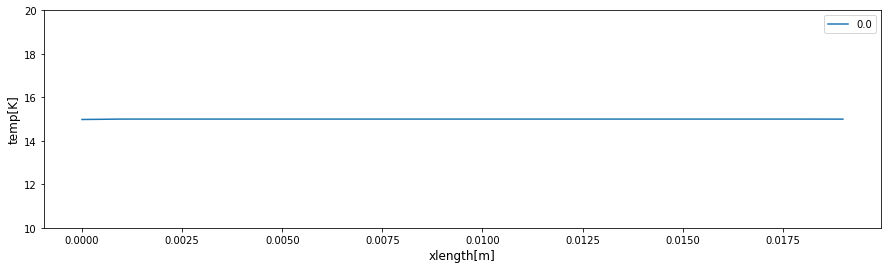

5.0 min


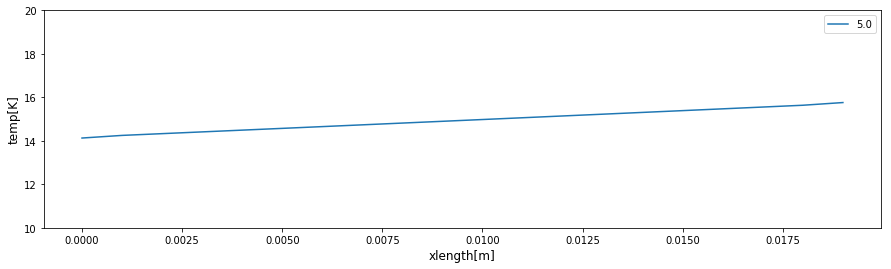

10.0 min


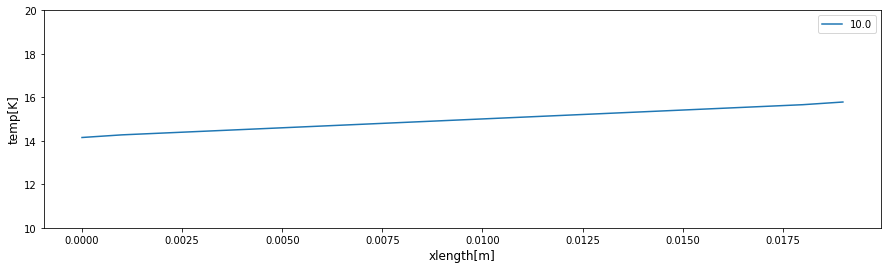

15.0 min


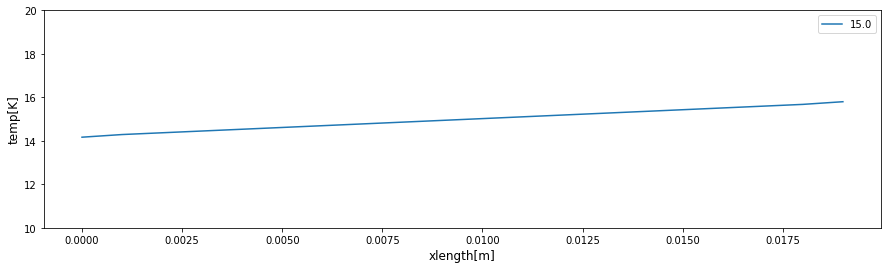

20.0 min


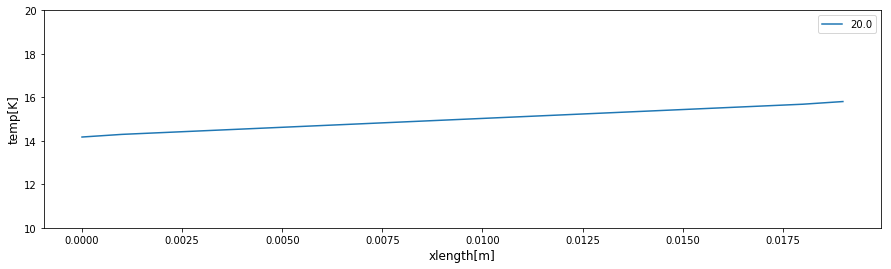

25.0 min


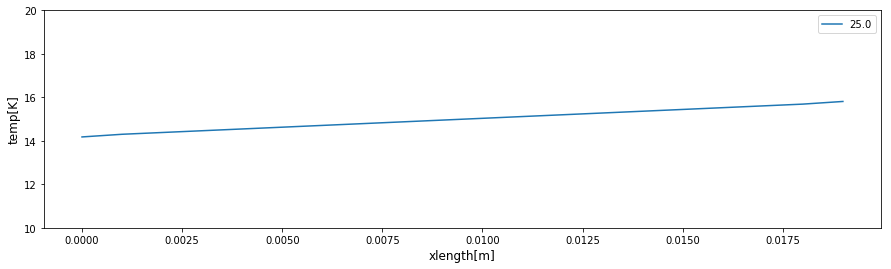

30.0 min


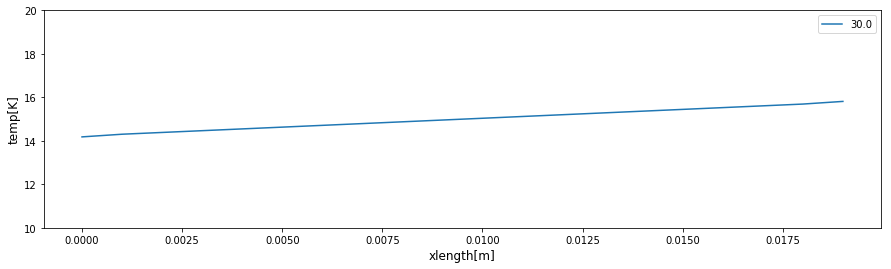

35.0 min


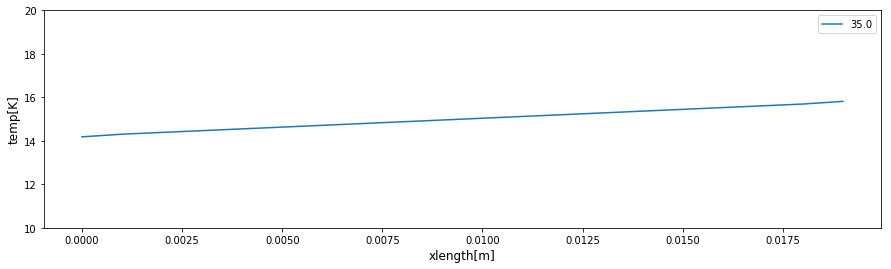

40.0 min


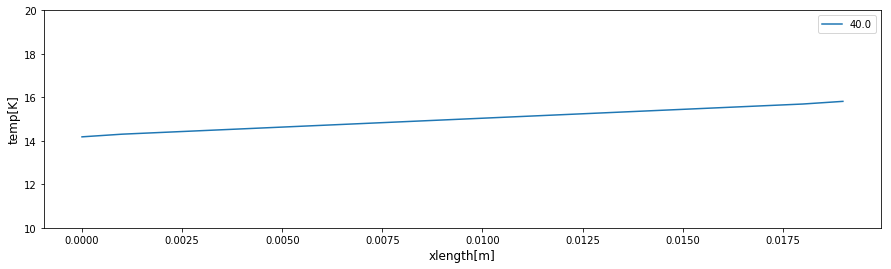

45.0 min


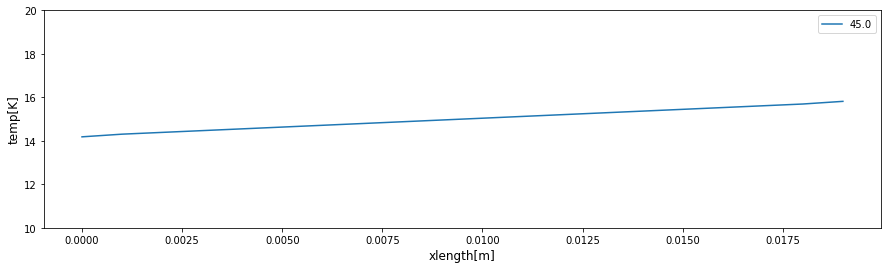

50.0 min


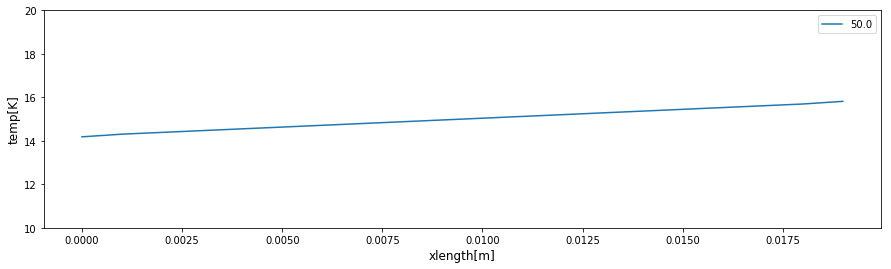

55.0 min


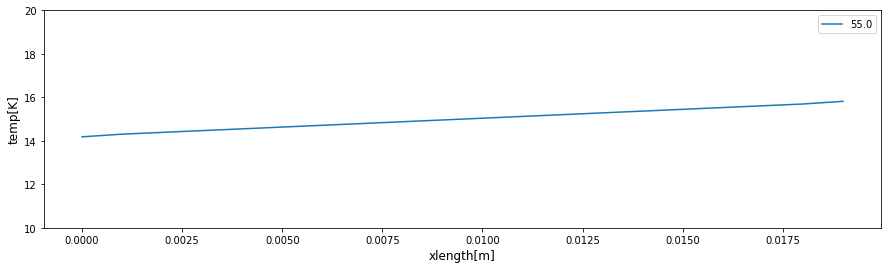

60.0 min


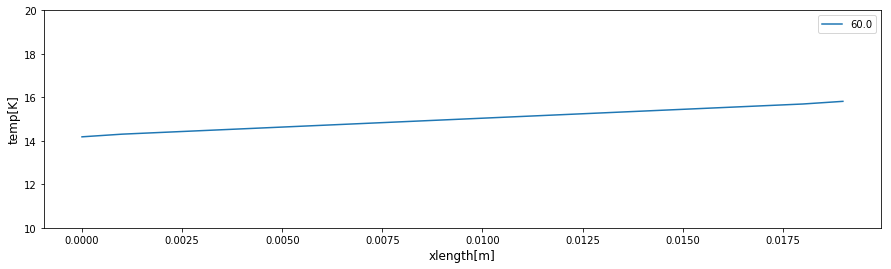

65.0 min


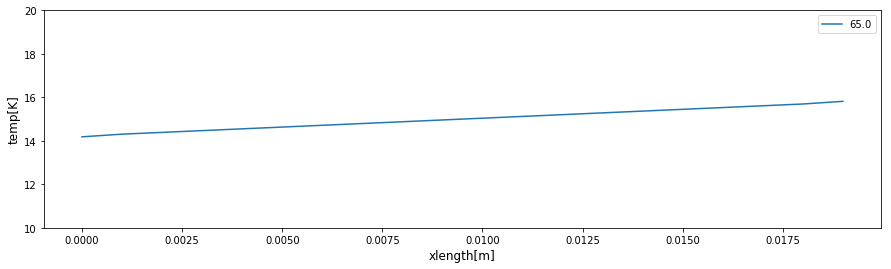

70.0 min


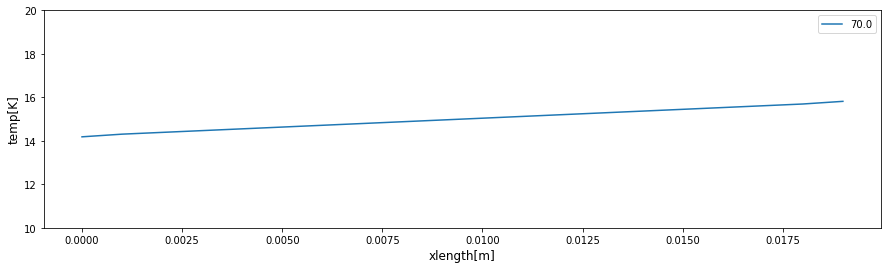

75.0 min


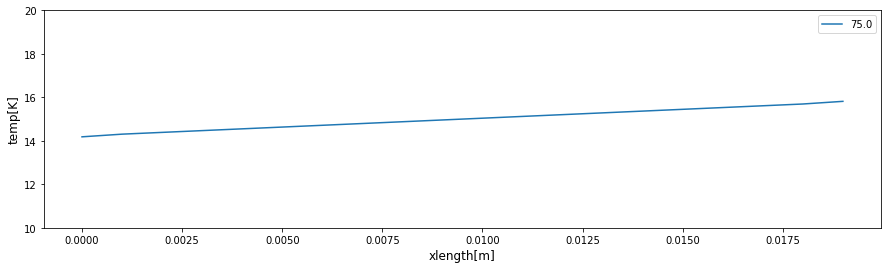

In [ ]:
import time
start = time.time()
for i in range( 360000 ):
    # 境界条件はループの外に 
    calc( cell, boundary_start, boundary_end, dt )
    #log.writeData( i, cell, dt )
    if i % 3000 == 0 :
        print( i * dt / 60.0,"min")
        #print( cell[0].vol / cell[0].dx, cell[0].miulc, time.time()-start )
        drawGraph( cell, i*dt/60.0 )
        
print('time',time.time() - start)

In [ ]:
# draw graph
time = len(log.times)
c = log.cell[time-1]
temp = [ c[i].temp-273.15 for i in range(L) ]
dx =   [ c[i].position*c[i].dx for i in range(L) ]

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
ax.plot( dx, temp , label = log.times[time-1] )
ax.set_xlabel( 'xlength', fontsize = 12 )
ax.set_ylabel( 'temperature(K)', fontsize = 12 )
plt.legend()
plt.show()
